<a href="https://colab.research.google.com/github/Raptor56MTG/DiscordDraftBot/blob/main/OCR_MTGO_codeipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documentation



In [ ]:
# https://www.jaided.ai/easyocr/documentation/

# Imports

In [ ]:
!pip install torch torchaudio torchvision
!pip install easyocr
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
# the above uninstall and reinstall is due to the wonderful compatiability issue below.
# https://stackoverflow.com/questions/70537488/cannot-import-name-registermattype-from-cv2-cv2

In [2]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import math
import difflib

# Autocorrect for usernames

In [42]:
USERLIST = []
with open('usernames.txt') as f:
    for line in f: 
        username = line.strip()
        USERLIST.append(username)

SCORES = []
for i in range (0, 15):
    for j in range (0, 15):
        SCORES.append(f'{i}-{j}')
SCORES.append('1-1-1')
SCORES.append('2-1-1')
SCORES.append('2-1-2')
SCORES.append('2-1-3')

In [90]:
def get_best_match_username(username):
  possibilities = USERLIST
  n = 3
  cutoff = 0.75
  best_match = difflib.get_close_matches(username, possibilities, n, cutoff)
  if len(best_match) > 0:
    return (best_match[0], 'pass')
  else:
    return (username, 'fail')

def get_best_match_score(score):
  possibilities = SCORES
  n = 3
  cutoff = 0.75
  best_match = difflib.get_close_matches(score, possibilities, n, cutoff)
  if len(best_match) > 0:
    return best_match[0].replace('-', ',')
  else:
    return score

get_best_match_username('Raptor56')

('Raptor56', 'pass')

# Helper Function to Display Images

In [16]:
def display(im_path):
    # code I ripped off stackoverflow to display images nicely. (https://stackoverflow.com/questions/28816046/)
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

# Image Locations


In [74]:
# NOTE: you only need to upload image.png. The rest are generated.
import os
IMAGE_PATH = 'image.png'
IMAGE_RESIZED = 'image-resized.png'
IMAGE_GRAY = 'image-gray.png'
IMAGE_FINAL = 'image-final.png'
IMAGE_DISPLAYED = 'image-displayed.png'
os.path.isfile(IMAGE_PATH)

True

# Display Original Image

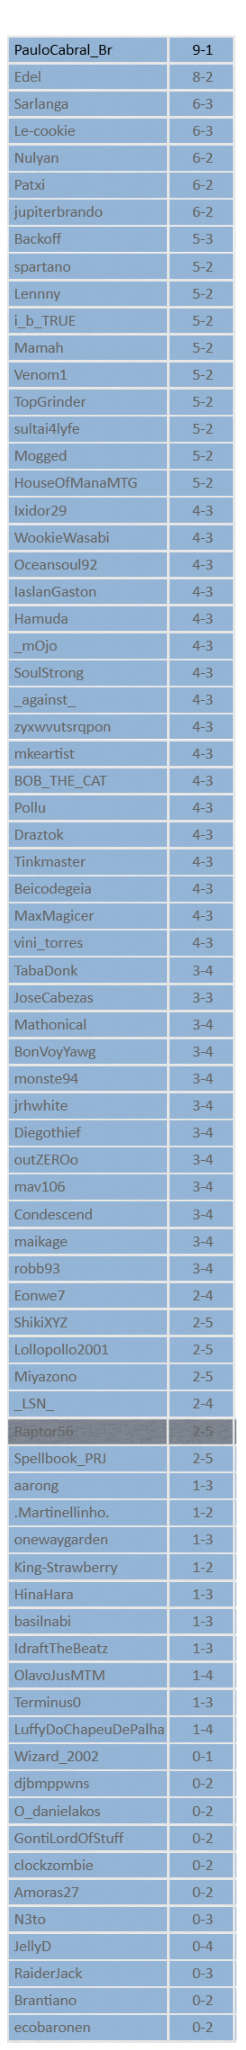

In [75]:
display(IMAGE_PATH)

# Preimage Processing

In [76]:
# Resize Image (increase)
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)
ratio = 3
width = int(ratio * img.shape[1])
height = int(ratio * img.shape[0])
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('image-resized.png', resized)

True

In [ ]:
# display(IMAGE_RESIZED)

In [77]:
# Grayscale Image
img = cv2.cvtColor(cv2.imread(IMAGE_RESIZED), cv2.COLOR_BGR2RGB) # fix color issue (rgb vs bgr)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('image-gray.png', gray_image)

True

In [ ]:
# display(IMAGE_GRAY)

In [78]:
# Binary Image with Thresholding
thresh, im_bw = cv2.threshold(gray_image, 165, 255, cv2.THRESH_BINARY)
cv2.imwrite('image-final.png', im_bw)

True

In [ ]:
display(IMAGE_FINAL)

# Run easyOCR

In [80]:
reader = easyocr.Reader(['en'])
results = reader.readtext(IMAGE_FINAL)

# Display what easyOCR found

In [81]:
img = cv2.imread(IMAGE_RESIZED)
for result in results:
    top_left = tuple([int(result[0][0][0]), int(result[0][0][1])])
    bottom_right = tuple([int(result[0][2][0]), int(result[0][2][1])])
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
cv2.imwrite('image-displayed.png', img)

True

In [ ]:
for r in results:
  print(r)

In [ ]:
display(IMAGE_DISPLAYED)

In [91]:
def correct_easyOCR(line: list, newline: bool):
    """This fixes some common errors that easyOCR applies
    to mtgo data and returns it as a corrected csv string.\n
    These include:
        - 21 instead of 2-1
        - 'username 2-1' instead of 'username,2-1'"""
    corrected_list = []

    # username is split up (most likely)
    if len(line) > 2:
      corrected_list.append("".join(line[:-1]))
      corrected_list.append(line[-1])
    elif len(line) == 2:
      corrected_list = line
    else:
      return

    if len(corrected_list) == 2:
      username = get_best_match_username(corrected_list[0])
      if username[1] == 'pass':
        return f'{username[0]},,{get_best_match_score(corrected_list[1])}'
      else:
        return f'{username[0]},,{get_best_match_score(corrected_list[1])},CHECK'
    return line


def generate_csv(results: list):
    """generates a csv file from the results that
    easyOCR generated. This applies fine tuning to
    mtgo data images. For anything else, it returns
    what easyOCR found."""
    line = []
    level = 0 # used to add newline when word moves down a row
    with open("output.csv", "w") as file:
        for reading in results:
            if reading[0][0][0] < level: # we are on a new line
                print(f'{correct_easyOCR(line, True)}')
                file.write(f"\n{correct_easyOCR(line, True)},")
                line = []
                line.append(reading[1])
            else:
                line.append(reading[1])
            level = reading[0][0][0]
        # for last line in file
        print(f'{correct_easyOCR(line, True)}')
        file.write(f"\n{correct_easyOCR(line, True)},")
generate_csv(results)


PauloCabral_Br,,9,1
Edel,,8,2
Sarlanga,,6,3
Le-cookie,,6,3
Nulyan,,6,2
Patxi,,6,2
jupiterbrando,,6,2
Backoff,,5,3
spartano,,5,2
Lennny,,5,2
i_b_TRUE,,5,2
Mamah,,5,2
Venom1,,5,2
TopGrinder,,5,2
sultai4lyfe,,5,2
Mogged,,5,2
HouseOfManaMTG,,5,2
Ixidor29,,4,3
WookieWasabi,,4,3
Oceansoul92,,4,3
IaslanGaston,,4,3
Hamuda,,4,3
_mOjo,,4,3
SoulStrong,,4,3
_against_,,4,3
zvxuvutsrqpon,,4,3,CHECK
mkeartist,,4,3,CHECK
BOB_THE_CAT,,4,3
Pollu,,4,3,CHECK
Draztok,,4,3
Tinkmaster,,4,3
Beicodegeia,,4,3
MaxMagicer,,4,3
vini_torres,,4,3
TabaDonk,,3,4
JoseCabezas,,3,3
Mathonical,,3,4
BonVoyYawg,,3,4
monste94,,3,4
jrhwhite,,3,4
Diegothief,,3,4
outZEROo,,3,4
mav106,,3,4,CHECK
Condescend,,3,4
maikage,,3,4,CHECK
robb93,,3,4
Eonwe7,,2,4
ShikiXYZ,,2,5
Lollopollo2001,,2,5
Miyazono,,2,5
_LSN_,,2,4
Spellbook_PRI,,2,5,CHECK
aarong,,1,3
.Martinellinho.,,1,2
onewaygarden,,1,3
King-Strawberry,,1,2
HinaHara,,1,3
basilnabi,,1,3
IdraftTheBeatz,,1,3
OlavoJusMTM,,1,4
Terminus0,,1,3
LuffyDoChapeuDePalha,,1,4
Wizard_2002,,0,1


In [28]:
# Stores possible score readings that easyOCR might generate. 
score_readings = []
for i in range (0, 15):
    for j in range (0, 15):
        score_readings.append(f'{i}{j}')
        score_readings.append(f'{i}-{j}')
    score_readings.append(f'{i}')

# A dictionary to map bad score readings from easyOCR,
# to good their correct counterpart. example: xy --> x-y
correct_scores = {}
for i in range (0, 15):
    for j in range (0, 15):
        correct_scores[f'{i}{j}'] = f'{i}-{j}'

def cleanup(mtgo):
    """removes image from system after reading."""
    if mtgo:
        os.remove('image-triple.png')
        os.remove('image-final.png')
    os.remove('image.png')
    os.remove('output.csv')


def correct_easyOCR(reading: str, newline: bool):
    """This fixes some common errors that easyOCR applies
    to mtgo data and returns it as a corrected csv string.\n
    These include:
        - 21 instead of 2-1
        - 'username 2-1' instead of 'username,2-1'"""
    
    r = reading.split()
    bad_string = False
    
    if len(r) > 1:
        for element in r:
            if element in score_readings:
                bad_string = True    
    if not newline:
        for i in range(len(r)):
            if r[i] in correct_scores.keys():
                r[i] = correct_scores[r[i]]
    if bad_string:
        return ','.join(r)
    else:
        return ''.join(r)


def generate_csv(results: list):
    """generates a csv file from the results that
    easyOCR generated. This applies fine tuning to
    mtgo data images. For anything else, it returns
    what easyOCR found."""

    level = 0 # used to add newline when word moves down a row
    with open("output.csv", "w") as file:
        for reading in results:
            if reading[0][0][0] < level: # we are on a new line
                level = reading[0][0][0]
                print(f"\n{correct_easyOCR(reading[1], True)},", end="")
                file.write(f"\n{correct_easyOCR(reading[1], True)},")
            else:
                level = reading[0][0][0]
                print(f"{correct_easyOCR(reading[1], False)},", end="")
                file.write(f"{correct_easyOCR(reading[1], False)},")

generate_csv(results)

Name,IRecord,
PauloCabral,Br,9-1,
Edel,8-2,
Sarlanga,6-3,
Le-cookie,6-3,
Nulyan,6-2,
Patxi,6-2,
jupiterbrando,6-2,
Backoff,5-3,
spartano,5-2,
Lennny,5-2,
b_TRUE,5-2,
Mamah,5-2,
Venoml,5-2,
TopGrinder,5-2,
sultai4lyfe,5-2,
Mogged,5-2,
HouseOfManaMTG,5-2,
Ixidor2g,4-3,
WaokieWasabi,4-3,
Oceansoul92,4-3,
laslanGaston,4-3,
Hamuda,4-3,
mOjo,4-3,
SoulStrong,4-3,
against_,4-3,
zvxuvutsrqpon,4-3,
mkeartist,4-3,
BOB_THE_CAT,4-3,
Pollu,4-3,
Draztok,4-3,
Tinkmaster,4-3,
Beicodegeia,4-3,
MaxMagicer,4-3,
vini_,torres,4-3,
TabaDonk,3-4,
JoseCabezas,3-3,
Mathonical,3-4,
BonVoyYawg,3-4,
monste94,3-4,
jrhwhite,3-4,
Diegothief,3-4,
outzEROo,3-4,
mav106,3-4,
Condescend,3-4,
maikage,3-4,
robb93,3-4,
Fonwe7,2-4,
ShikixYz,2-5,
Lollopollo2O01,2-5,
Miyazono,2-5,
LSN,2-4,
Spellbook_PRI,2-5,
aarong,1-3,
Martinellinho.,1-2,
onewaygarden,1-3,
King-Strawberry,1-2,
HinaHara,1-3,
basilnabi,1-3,
IdraftTheBeatz,1-3,
OlavoJusMTM,1-4,
Terminuso,1-3,
LuffyDoChapeuDePalha,1-4,
Wizard2002,0-1,
djbmppwns,0-2,
0_danielakos,0

# Show Results

In [ ]:
for result in results:
  print(result)

In [ ]:
#standardize the list of y-values so they can be used as row numbers
pixel_width = im_bw.shape[0]
CELL_WIDTH_MULTIPLIER = 1/75
CELL_HEIGHT_MULTIPLIER = 1/200
points = [i[0][0] for i in results]
rows = []
columns = []
for point in points:
  for row in rows:
    if abs(sum(row)/len(row) - point[1]) < (pixel_width*CELL_HEIGHT_MULTIPLIER): #if this box is close to other boxes, add it to that bin
      row += point[1],
      break
  else: #if it's not close to anybody so far, make a new bin
    rows += [point[1]],

  for column in columns:
    if abs(sum(column)/len(column) - point[0]) < (pixel_width*CELL_WIDTH_MULTIPLIER): #if this box is close to other boxes, add it to that bin
      column += point[0],
      break
  else: #if it's not close to anybody so far, make a new bin
    columns += [point[0]],

rows =  sorted([round(sum(i)/len(i)) for i in rows]) #get a single number to represent each bin
columns =  sorted([round(sum(i)/len(i)) for i in columns])
#print(f"{len(rows)} rows"); print(rows); print(f"{len(columns)} columns"); print(columns)

#overwrite the top and left lines of the bounding boxes
for result in results:
  result[0][0][1] = result[0][1][1] = min(rows, key=lambda x: abs(x - result[0][0][1]))
  result[0][0][0] = result[0][3][0] = min(columns, key=lambda x: abs(x - result[0][0][0]))

results.sort(key= lambda x: x[0][0][::-1])

In [ ]:
# Stores possible score readings that easyOCR might generate. 
score_readings = []
for i in range (0, 15):
    for j in range (0, 15):
        score_readings.append(f'{i}{j}')
        score_readings.append(f'{i}-{j}')
    score_readings.append(f'{i}')

    
# A dictionary to map bad score readings from easyOCR,
# to good their correct counterpart. example: xy --> x-y
correct_scores = {}
for i in range (0, 15):
    for j in range (0, 15):
        correct_scores[f'{i}{j}'] = f'{i}-{j}'
        
    
def correct_easyOCR(result: str, newline: bool):
    """This fixes some common errors that easyOCR applies
    to mtgo data and returns it as a corrected csv string.\n
    These include:
        - 21 instead of 2-1
        - 'username 2-1' instead of 'username,2-1'"""
    
    r = result.split()
    bad_string = False
    
    if len(r) > 1:
        for element in r:
            if element in score_readings:
                bad_string = True    
    if not newline:
        for i in range(len(r)):
            if r[i] in correct_scores.keys():
                r[i] = correct_scores[r[i]]
    if bad_string:
        return ','.join(r)
    else:
        return ''.join(r)


resultindex = 0
fixed_results = []
while resultindex < len(results):
    line = []
    for i in columns:
        if results[resultindex][0][0][0] == i:
            fixed_reading = correct_easyOCR(results[resultindex][1], i==columns[0])
            resultindex += 1
            #if there are multiple boxes for the same cell, merge them
            while resultindex < len(results) and results[resultindex][0][0][0] == i:
                fixed_reading += correct_easyOCR(results[resultindex][1], i==columns[0])
                resultindex += 1
        else:
            fixed_reading = ""
        line += fixed_reading,

    fixed_results += line,
    #this gets printed a bit later

In [ ]:
#Next, determine how many extra rows there are at the top (hopefully 0, 1 or 2), using the numbers in the leftmost column
#If the bot gets this wrong, do not proceed.
rowdiffs = [ (i - int(fixed_results[i][0])) for i in range(11) if fixed_results[i][0].isdigit() ]
n_diff = int(round(sum(rowdiffs)/len(rowdiffs))) + 1
if n_diff > 0:
    fixed_results = fixed_results[n_diff:]

playernames = [line[1] for line in fixed_results]
print(f"I think there are {len(fixed_results)} players.")
print(f"I think there are {round((len(fixed_results[0])-3)/2)} total rounds.")
print(f"Player names: {sorted(playernames)}")

I think there are 110 players.
I think there are 14 total rounds.
Player names: ['', 'A_AdeptoTerra', 'Aegisaziz', 'Alleyezonme', 'An_Actual', 'Backoff', 'Beicodegeia', 'Bielzito', 'Binolino', 'Bolawamor', 'Bryant_Cook', 'Condescend', 'CounterTopGarchomp', 'DarthBeleren', 'December18', 'DiemAx', 'Eaglov', 'Falcon_', 'Folero', 'FunkiMunki', 'Grantfly', 'Hamuda', 'Ike]', 'Ixidor2g', 'Jacobisboss', 'JakeHelms', 'Joao_Andrade', 'Jpsn54', 'Kirblinxy', 'L3091', 'LNT_', 'Lennny', 'LiturgijskaKnjiga', 'LuffyDoChapeuDePalha', 'MATTHEWFOULKES', 'MZBlazer', 'MagicianMagico', 'Mamah', 'Mathonical', 'MaxMagicer', 'McWinSauce', 'Mikhatharal9g4', 'Milkk', 'MissTrigeer', 'Niedzwiedz', 'Nm85', 'OlavolusMTM', 'Parallax', 'PauloCabral', 'Phizzle', 'RawwMain', 'Riickitun', 'RiuuK1', 'RubensNetto', 'SanPop', 'Sarlanga', 'SickWorld', 'Slasher21', 'Snusnumrck', 'StryCe', 'Swift213', 'ThaliaGa', 'UltimaThule', 'ValuePlay', 'Vertyx', 'WingedHussar', 'Xwhale', 'Ziene', '_Marian_', '_Tia93_', 'abijhavs', 'agains

In [ ]:
NONNAME_CELLS = ["", "(Bye)", "!!!!!!!!!!"]
#strings for: blank-cell, bye, bot-error

def get_real_name(text, playernames=playernames):
    """ Take a name and find the closest match. We can guarantee a list of options 
      to choose from by looking at the first player column, but if we have the 
      names spelled properly (from an external source) we could use that too."""  
    try:
        return difflib.get_close_matches(text, playernames + NONNAME_CELLS)[0]
    except IndexError: #None of the options were close enough. Just don't crash.
        return NONNAME_CELLS[2] 

round_name_cols = [i for i in range(3, len(fixed_results[0]), 2)]
round_score_cols = [i for i in range(4, len(fixed_results[0]), 2)]

def colnum_to_roundnum(colnum):
    if colnum < 3 or colnum > len(fixed_results[0]): 
        return 0
    nrounds = round((len(fixed_results[0])-3)/2)
    return nrounds - (colnum - 3)// 2

## Iterate over all the player-name-cells in the image, and replace them with 
## the correct spellings from the first name-column.
for colnum in round_name_cols:
    for rownum in range(len(fixed_results)):
        fix = get_real_name(fixed_results[rownum][colnum])
        if fixed_results[rownum][colnum] != fix:
            fixed_results[rownum][colnum] = fix
            #print(fixed_results[rownum][colnum], "->", fix)
  
for line in fixed_results: 
    print(line)

['', 'PauloCabral', 'Br', '!!!!!!!!!!', 'Nr85', '!!!!!!!!!!', 'Alleyezonme', '!!!!!!!!!!', 'Jpsn54', '!!!!!!!!!!', 'Kirblinxy', '', '2-1', 'Vertyx', '', '!!!!!!!!!!', 'canvs', '', '2-1', 'Aegisaziz', '', '!!!!!!!!!!', '0_danielakos', '', '2-0', 'Snusnumrck', '', '!!!!!!!!!!', 'pacoelflaco', '', '1-2']
['', 'Nm85', '', '!!!!!!!!!!', 'PauloCabral_Br', '!!!!!!!!!!', 'ecobaronen', '!!!!!!!!!!', 'SickWorld', '!!!!!!!!!!', 'OlavoJusMTM', '', '0-2', 'SickWorld', '', '!!!!!!!!!!', 'pacoelflaco', '', '2-1', 'Alleyezonme', '', '!!!!!!!!!!', 'MagicianMagico', '', '2-0', 'barff', '', '!!!!!!!!!!', 'Phizzle', '', '2-0']
['', 'Alleyezonme', '', '!!!!!!!!!!', '', '', 'PaulaCabral_Br', '!!!!!!!!!!', 'OlavoJusMTM', '!!!!!!!!!!', 'Lennny', '', '2-0', 'pacoelflaco', '', '!!!!!!!!!!', 'outZEROo', '', '2-1', 'Nm85', '', '!!!!!!!!!!', 'nildo', '', '2-0', 'Ziene', '', '!!!!!!!!!!', 'apas72', '', '2-0']
['', 'ecobaronen', '', '!!!!!!!!!!', '', '', 'Nm85', '!!!!!!!!!!', 'Ike]', '!!!!!!!!!!', 'xTheGorillaz', ''

# Sanity Checks

In [ ]:
problems = []
#Check #1: Each player's score should equal the sum of the match outcomes across their row
for row in fixed_results:
    x = row[2]
    if x == "":
        problems += f"Unable to sanity check {row[1]}'s matches because their total score was not read.",
        continue
    goal_w = int(x[:x.index("-")])
    goal_l = int(x[x.index("-")+1:])
    obs_w = 0
    obs_l = 0
    for i in range(len(round_name_cols)):
        if row[round_name_cols[i]] not in NONNAME_CELLS:
            try:
                game_w = int(row[round_name_cols[i]+1][0])
                game_l = int(row[round_name_cols[i]+1][2])
                if game_w > game_l:
                    obs_w += 1
                elif game_w < game_l:
                    obs_l += 1
                #TODO: handle matches that contain a draw
            except (IndexError, ValueError):
                problems = [f"I can't read the result for {row[1]}'s match in round {colnum_to_roundnum(round_name_cols[i])}."] + problems
                #This is the first time we're checking this so let's log it here, and nowhere else
    if goal_w != obs_w or goal_l != obs_l:
        problems += f"{row[1]} apparently went {goal_w}-{goal_l} but their matches add up to {obs_w}-{obs_l}.",

#Check #2: Within each round, the total number of game wins should be equal to the total number of game losses
for r in round_score_cols:
    col_w = 0
    col_l = 0
    for row in fixed_results:
        score = row[r]
        try:
            col_w += int(score[0])
            col_l += int(score[2])
        except (IndexError, ValueError):
            continue #we already complained about this in check #1
    if col_w > col_l:
        problems += f"In round {colnum_to_roundnum(r)}, there are {col_w} game wins and only {col_l} game losses.",
    elif col_w < col_l:
        problems += f"In round {colnum_to_roundnum(r)}, there are {col_l} game wins and only {col_w} game losses.",


#Check #3: Every match on the sheet should appear a second time somewhere else on the sheet
##TODO
pair_dict = {}
for row in fixed_results:
    p1 = row[1]
    if p1 not in NONNAME_CELLS:
        for colnum in round_name_cols:
            p2 = row[colnum]
            if p2 not in NONNAME_CELLS:
                tup = tuple(sorted([p1, p2]))
                pair_dict[tup] = pair_dict.setdefault(tup, 0) + 1
for k, v in pair_dict.items():
    if v == 1:
        problems += f"The {k[0]} vs {k[1]} match is only seen once (it should be twice).",
    elif v > 2:
        problems += f"The {k[0]} vs {k[1]} match is seen {v} times (it should be only 2).",

#Check #4: Within each round, no player should appear more than once
for i in round_name_cols:
    players = []
    for j in fixed_results:
        player = j[i]
        if player in NONNAME_CELLS:
            continue
        if player not in players:
            players += player,
        else:
            problems += f"{player} appears more than once in round {colnum_to_roundnum(i)}",

for p in problems:
    print(p)
if not len(problems):
    print("All checks passed!")

ValueError: ignored